In [1]:
import os
DATA_PATH = '/kaggle/input/unsw-nb15'   # adjust only if your dataset folder name differs
print("Listing files in dataset folder:")
for root, dirs, files in os.walk(DATA_PATH):
    for f in files:
        print(os.path.join(root, f))


Listing files in dataset folder:
/kaggle/input/unsw-nb15/UNSW_NB15_testing-set.csv
/kaggle/input/unsw-nb15/UNSW-NB15_1.csv
/kaggle/input/unsw-nb15/UNSW_NB15_training-set.csv
/kaggle/input/unsw-nb15/UNSW-NB15_LIST_EVENTS.csv
/kaggle/input/unsw-nb15/UNSW-NB15_4.csv
/kaggle/input/unsw-nb15/UNSW-NB15_3.csv
/kaggle/input/unsw-nb15/UNSW-NB15_2.csv
/kaggle/input/unsw-nb15/NUSW-NB15_features.csv


In [2]:
import os, pandas as pd

DATA_PATH = "/kaggle/input/unsw-nb15"
train_fn = os.path.join(DATA_PATH, "UNSW_NB15_training-set.csv")
test_fn  = os.path.join(DATA_PATH, "UNSW_NB15_testing-set.csv")

df_train = pd.read_csv(train_fn)
df_test  = pd.read_csv(test_fn)

df_train.shape, df_test.shape, df_train.head(3)


((82332, 45),
 (175341, 45),
    id       dur proto service state  spkts  dpkts  sbytes  dbytes  \
 0   1  0.000011   udp       -   INT      2      0     496       0   
 1   2  0.000008   udp       -   INT      2      0    1762       0   
 2   3  0.000005   udp       -   INT      2      0    1068       0   
 
           rate  ...  ct_dst_sport_ltm  ct_dst_src_ltm  is_ftp_login  \
 0   90909.0902  ...                 1               2             0   
 1  125000.0003  ...                 1               2             0   
 2  200000.0051  ...                 1               3             0   
 
    ct_ftp_cmd  ct_flw_http_mthd  ct_src_ltm  ct_srv_dst  is_sm_ips_ports  \
 0           0                 0           1           2                0   
 1           0                 0           1           2                0   
 2           0                 0           1           3                0   
 
    attack_cat  label  
 0      Normal      0  
 1      Normal      0  
 2      Normal   

In [3]:
import numpy as np
import pandas as pd

label_col = "label"  # 0 = Normal, 1 = Attack in UNSW-NB15

# mark split, concat so one-hot columns align, then build X/y
df_train["__split"] = "train"
df_test["__split"]  = "test"
df_all = pd.concat([df_train, df_test], ignore_index=True)

# columns to drop (IDs / potential leakage)
drop_cols = [c for c in ["id","srcip","dstip","sport","dport","stime","ltime",label_col] if c in df_all.columns]

# small set of categoricals to one-hot if present
cat_candidates = ["proto","service","state","is_ftp_login"]  # last is already numeric in some releases; harmless if absent
cat_cols = [c for c in cat_candidates if c in df_all.columns]

num = df_all.drop(columns=drop_cols + cat_cols, errors="ignore").select_dtypes(include=[np.number]).fillna(0)
dmy = pd.get_dummies(df_all[cat_cols], drop_first=True) if cat_cols else pd.DataFrame(index=df_all.index)
X_all = pd.concat([num, dmy], axis=1)
y_all = df_all[label_col].astype(int)

print("X_all:", X_all.shape, "| y dist:", y_all.value_counts(normalize=True))

# split back to train/test
mask = df_all["__split"] == "train"
X_train, y_train = X_all[mask], y_all[mask]
X_test,  y_test  = X_all[~mask], y_all[~mask]
X_train.shape, X_test.shape


X_all: (257673, 193) | y dist: label
1    0.639077
0    0.360923
Name: proportion, dtype: float64


((82332, 193), (175341, 193))

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

clf = RandomForestClassifier(
    n_estimators=300, n_jobs=-1, random_state=42, class_weight="balanced"
)
clf.fit(X_train, y_train)

y_pred  = clf.predict(X_test)
y_prob  = clf.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred, target_names=["Normal","Attack"]))
print("ROC AUC:", roc_auc_score(y_test, y_prob))


              precision    recall  f1-score   support

      Normal       0.78      0.98      0.87     56000
      Attack       0.99      0.87      0.93    119341

    accuracy                           0.90    175341
   macro avg       0.88      0.92      0.90    175341
weighted avg       0.92      0.90      0.91    175341

ROC AUC: 0.9836788071726037


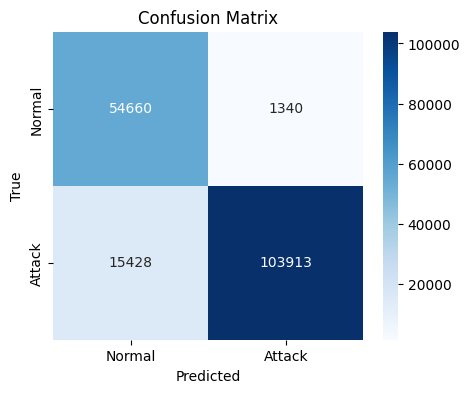

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal","Attack"],
            yticklabels=["Normal","Attack"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


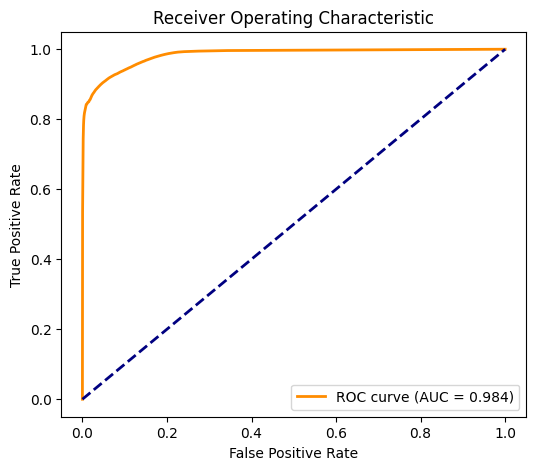

In [6]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()


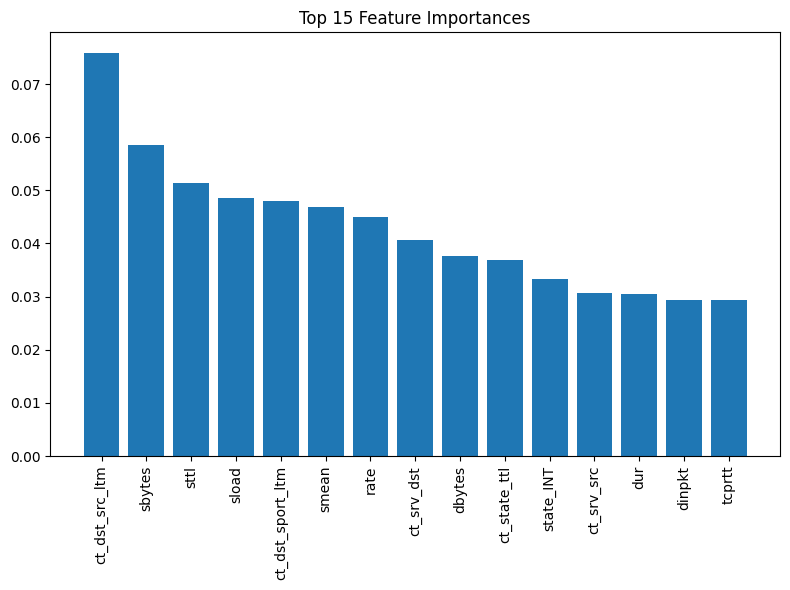

In [7]:
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot top 15 features
plt.figure(figsize=(8,6))
plt.title("Top 15 Feature Importances")
plt.bar(range(15), importances[indices[:15]], align="center")
plt.xticks(range(15), X_train.columns[indices[:15]], rotation=90)
plt.tight_layout()
plt.show()


In [8]:
import joblib

# Save model
joblib.dump(clf, "/kaggle/working/ids_random_forest.pkl")

# Save predictions
import pandas as pd
pd.DataFrame({
    "y_true": y_test,
    "y_pred": y_pred,
    "y_prob": y_prob
}).to_csv("/kaggle/working/predictions_sample.csv", index=False)
